In [1]:
#************************************************************************************
# Rezwan Matin
# Thesis B
# Filename: ML_MLP_RAVDESS_1.py
# Date: 2/16/20
#
# Objective:
# 26 MFCCs (mean) and 26 MFCCs (standard deviation), ZCR.
#
#*************************************************************************************

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa as rosa
import glob
import os
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
# Save directory path in 'path'
path = r'C:\Books\Texas State Books\Fall 2019\Thesis A\Corpus\Simulated\RAVDESS\All'

# Declare a dummy Numpy array (row vector)
result_array = np.empty([1,54])

# Create a list of audio file names 'file_list'
file_list = os.listdir(path)

i=0

for filename in file_list:
    
    # Read WAV file. 'rosa.core.load' returns sampling frequency in 'fs' and audio signal in 'sig'
    sig, fs = rosa.core.load(path + '\\' + file_list[i], sr=None)
    
    # Calculate the average mfcc (utterance-level features) using 'rosa.feat.mfcc()' and 'np.mean' method. '.T' transposes the rows and columns. 'axis=0' indicates average is calculated column-wise
    avg_mfcc_feat = np.mean(rosa.feature.mfcc(y=sig, sr=fs, n_mfcc=26).T,axis=0)
    
    # Calculate the standard deviation of mfcc (utterance-level features) using 'rosa.feat.mfcc()' and 'np.std' method. '.T' transposes the rows and columns. 'axis=0' indicates average is calculated column-wise
    std_mfcc_feat = np.std(rosa.feature.mfcc(y=sig, sr=fs, n_mfcc=26).T,axis=0)
    
    # Calculate the average zero crossing rate (utterance-level feature) using 'rosa.feat.zero_crossing_rate()' and 'np.mean' method. '.T' transposes the rows and columns. 'axis=0' indicates average is calculated column-wise
    zcross_feat = rosa.feature.zero_crossing_rate(sig)
    avg_zcross_feat = np.mean(rosa.feature.zero_crossing_rate(y=sig).T,axis=0)
    
    # Append the three 1D arrays into a single 1D array called 'feat'.
    feat0 = np.append(avg_mfcc_feat, std_mfcc_feat, axis=0)
    
    feat1 = np.append(feat0, avg_zcross_feat, axis=0)
    
    # Save emotion label from file name. 'path' contains directory's address, 'file_list' contains file name, and '\\' joins the two to form file's address
    label = os.path.splitext(os.path.basename(path + '\\' + file_list[i]))[0].split('-')[2]
    
    # Create a new Numpy array 'sample' to store features along with label
    sample = np.insert(feat1, obj=53, values=label)
    
    result_array = np.append(result_array, sample)
    
    i+=1

# Print out the 1D Numpy array
result_array

array([1.48219694e-322, 1.43370704e-315, 1.38338381e-322, ...,
       9.32265673e+000, 9.21448291e-002, 8.00000000e+000])

In [3]:
result_array.shape

(77814,)

In [4]:
# Convert 1D Numpy array to 2D array
result_array = np.reshape(result_array, (i+1,-1))

# Delete first dummy row from 2D array
result_array = np.delete(result_array, 0, 0)

# Print final 2D Numpy array 
result_array.shape

(1440, 54)

In [5]:
df = pd.DataFrame(data=result_array)
# Label only the last (target) column
df = df.rename({53: "Emotion"}, axis='columns')
# Delete unnecessary emotion data (calm)
df.drop(df[df['Emotion'] == 2.0].index, inplace = True)
# Reset row (sample) indexing
df = df.reset_index(drop=True)
df.tail(12)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,Emotion
1236,-596.489909,60.752540,1.096842,10.348159,-2.365429,7.986745,-2.027191,-0.116491,-6.654691,-1.406857,...,4.855516,7.889321,6.462217,6.308829,6.093730,4.775629,6.743428,4.953056,0.066450,8.0
1237,-625.565085,37.601565,-3.692515,8.979277,-5.637381,1.969832,-14.028974,1.621135,-13.249778,-2.752983,...,8.569099,9.995390,9.139846,7.003860,8.466257,6.507719,6.422495,7.017977,0.100822,8.0
1238,-589.096402,81.593995,-0.673410,12.050125,10.394698,19.574634,-4.826030,2.336833,-1.092758,-2.186526,...,7.340301,6.230392,6.443201,8.798983,4.902457,4.589814,7.527595,4.950332,0.060662,8.0
1239,-567.861314,50.748331,-6.996325,2.507971,-4.691477,0.188368,-15.399068,-8.173095,-10.797020,-5.656966,...,11.171980,8.206702,7.901195,8.828436,9.154752,9.932455,9.488486,9.067261,0.071194,8.0
1240,-493.306198,48.233703,-3.028220,18.852342,-3.590502,9.721251,-2.724754,6.184319,-1.879220,2.796708,...,8.423227,8.431807,10.100727,6.233350,5.368571,6.040829,8.945960,9.681306,0.068974,8.0
1241,-615.406134,43.642912,-6.402692,12.012579,-11.143824,5.057568,-10.034647,9.767619,-5.317049,-4.267572,...,8.939621,6.847688,8.352500,6.104008,9.562205,9.682800,7.298084,11.122962,0.062682,8.0
1242,-696.193632,72.680527,6.986117,24.891391,2.902952,9.812980,1.004795,9.548923,-5.149150,-1.495172,...,6.992092,7.291586,6.982269,7.322814,5.810611,5.193900,8.329027,4.884544,0.053795,8.0
1243,-615.786554,53.243328,-18.664904,4.902306,-5.074936,2.717509,-12.459353,0.465174,-15.718720,-9.009732,...,8.659487,9.041492,9.361286,8.517360,8.430611,9.607357,7.680336,10.634757,0.073165,8.0
1244,-540.863667,61.330114,-9.318194,14.311654,0.700296,10.042510,-8.720129,-2.253887,-3.264636,-8.769154,...,6.450383,7.456291,5.409208,5.574703,5.130295,6.740843,6.362919,4.742207,0.069006,8.0
1245,-560.186503,44.504401,-14.639301,2.251491,-11.031190,5.346806,-10.163466,-6.553192,-9.599661,-7.118306,...,8.714345,12.087737,11.294306,11.975909,15.346170,10.152889,10.284631,8.092669,0.083883,8.0


In [6]:
df['Emotion'].value_counts()

8.0    192
7.0    192
6.0    192
5.0    192
4.0    192
3.0    192
1.0     96
Name: Emotion, dtype: int64

In [7]:
# Balance the dataset for equal number of samples for each class.
# Separate majority and minority classes
df_minority = df[df.Emotion==1.0]
df_majority3 = df[df.Emotion==3.0]
df_majority4 = df[df.Emotion==4.0]
df_majority5 = df[df.Emotion==5.0]
df_majority6 = df[df.Emotion==6.0]
df_majority7 = df[df.Emotion==7.0]
df_majority8 = df[df.Emotion==8.0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=192,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority3, df_majority4, df_majority5, df_majority6, df_majority7, df_majority8])
 
# Display new class counts
df_upsampled.Emotion.value_counts()

# Reset row (sample) indexing
df_upsampled = df_upsampled.reset_index(drop=True)

df_upsampled['Emotion'].value_counts()

8.0    192
7.0    192
6.0    192
5.0    192
4.0    192
3.0    192
1.0    192
Name: Emotion, dtype: int64

In [8]:
# Extract target feature 'Emotion' in a vector y. Indexing from 0
y = df_upsampled.iloc[0:1344, 53].values
# Extract features 'buying' and 'safety' in a vector X. Indexing from 0
X = df_upsampled.iloc[0:1344, list(range(53))].values
print(y)

[1. 1. 1. ... 8. 8. 8.]


In [9]:
# Split data for training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

In [10]:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

# Standardize the inputs
X_train_centered = (X_train - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

del X_train, X_test

print(X_train_centered.shape, y_train.shape)
print(X_test_centered.shape, y_test.shape)

(1008, 53) (1008,)
(336, 53) (336,)


In [11]:
np.random.seed(123)

tf.set_random_seed(123)

# One-Hot Encode the classes
y_train_onehot = keras.utils.to_categorical(y_train)

In [12]:
# Create an object/instance 'model' for the 'Sequential()' class.
model = keras.models.Sequential()
model.add(
    keras.layers.Dense( units=53,
                input_dim=X_train_centered.shape[1],
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros', 
                activation='relu'))
model.add(
    keras.layers.Dense( units=53,
                input_dim=53,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                activation='relu'))
model.add(
    keras.layers.Dense( units=53,
                input_dim=53,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                activation='relu'))
model.add(
    keras.layers.Dense( units=53,
                input_dim=53,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                activation='relu'))

model.add(
    keras.layers.Dense( units=y_train_onehot.shape[1],
                input_dim=53,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
sgd_optimizer = keras.optimizers.SGD(
                    lr=0.001, decay=1e-7, momentum=0.9)

model.compile(optimizer=sgd_optimizer,
                    loss='categorical_crossentropy')
                          
                            # cross-entropy: fancy name for logistic regression

In [14]:
# Train the MLP
history = model.fit(X_train_centered, y_train_onehot, batch_size=64, epochs=50, verbose=1, validation_split=0.1) # 90% training / 10% validation

Train on 907 samples, validate on 101 samples
Epoch 1/50
907/907 [==============================] - 1s 805us/sample - loss: 2.1953 - val_loss: 2.1899
Epoch 2/50
907/907 [==============================] - 0s 262us/sample - loss: 2.1874 - val_loss: 2.1802
Epoch 3/50
907/907 [==============================] - 0s 97us/sample - loss: 2.1777 - val_loss: 2.1705
Epoch 4/50
907/907 [==============================] - 0s 71us/sample - loss: 2.1679 - val_loss: 2.1614
Epoch 5/50
907/907 [==============================] - 0s 64us/sample - loss: 2.1585 - val_loss: 2.1524
Epoch 6/50
907/907 [==============================] - 0s 62us/sample - loss: 2.1494 - val_loss: 2.1435
Epoch 7/50
907/907 [==============================] - 0s 66us/sample - loss: 2.1406 - val_loss: 2.1353
Epoch 8/50
907/907 [==============================] - 0s 93us/sample - loss: 2.1321 - val_loss: 2.1271
Epoch 9/50
907/907 [==============================] - 0s 71us/sample - loss: 2.1237 - val_loss: 2.1186
Epoch 10/50
907/907 [====

In [15]:
y_train_pred = model.predict_classes(X_train_centered, verbose=0)
correct_preds = np.sum(y_train == y_train_pred, axis=0)
train_acc = correct_preds / y_train.shape[0]

print('Training accuracy: %.2f%%' % (train_acc * 100))

Training accuracy: 28.87%


In [16]:
y_test_pred = model.predict_classes(X_test_centered, verbose=0)
correct_preds = np.sum(y_test == y_test_pred, axis=0)
test_acc = correct_preds / y_test.shape[0]

print('Test accuracy: %.2f%%' % (test_acc * 100))

Test accuracy: 30.95%


In [15]:
y_train_onehot.shape[1]

9

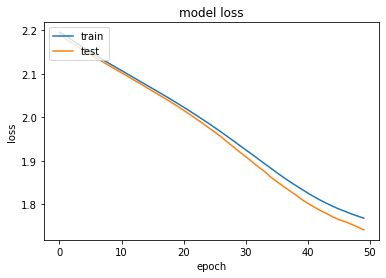

In [18]:
# Plot the Loss vs. Epochs curve
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save plot as PNG file
fig.savefig('Loss vs Epochs.png')